# 프로젝트: Make Shallow depth of field(Shallow focus)
* 목표
    - 인물사진 모드처럼 사진 만들기 
* 활용 개념 
    - Segmentation 알고리즘 
        - Semantic Segmentation
        - Instance Segmentation
        - Watershed Segmentation 
    - Segmentation 관련 모델
        - FCN
        - SegNet
        - U-Net
        - [DeepLab V3+](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/) 
* 프로젝트 구현 순서
    - Segmentation으로 피사체와 배경 분리하기
    - 블러링 적용해서 배경 흐리게 하기 
    - 분리한 인물, 배경 합성하기 
    - 사진에서 문제점 표시하기 
        - 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우
    - DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션

* 참고 출처
    - [피사계 심도 이해하기](https://ggyul.tistory.com/12)
    - [3D Depth Camera 활용하기](https://m.blog.naver.com/panoptics/221336152952)
    - [깊이 영상(Depth image) 활용하기1](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
)
    - [깊이 영상(Depth image) 활용하기2](https://sites.google.com/view/struct2depth)
    - [IR(적외선)을 활용한 사례](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import random

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 100
set_seeds(SEED)

## 인물모드 직접 해보기
1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성 합니다.

In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
      
print("done")

done


In [6]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj19/aiffel/human_segmentation/models
model loaded successfully!


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 사진에 한 사람만 있는 경우 

In [8]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(640, 480, 3)


In [9]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(640, 480, 3) (513, 384, 3) 15


In [10]:
# 인식 대상을 알기 위한 unique 
np.unique(seg_map)

array([ 0, 13, 15])

In [11]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) # segmentation 
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # original 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # resize mask

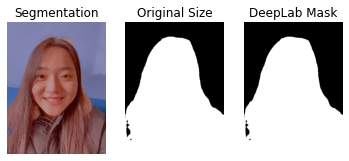

In [12]:
# segmentation, original mask, resize deeplab mask 결과 이미지 출력하기 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Segmentation')
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.set_title('Original Size')
ax2.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
ax3.set_title('DeepLab Mask')
ax3.imshow(img_mask, cmap=plt.cm.binary_r)
ax3.axis('off')

plt.show()

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 배경 마스크 만들기 
img_bg_blur = cv2.blur(img_bg, (13,13)) #  배경 흐리게 하기 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 흐린 배경과 포커싱 대상 이미지 합치기 

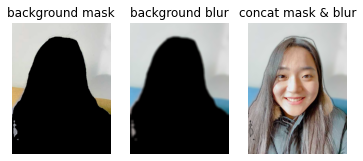

In [14]:
# mask, blur, concat 결과 이미지 출력하기 

fig = plt.figure()
rows = 1
cols = 3 

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img_bg) # img_bg
ax1.set_title('background mask')
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # img_bg_blur
ax2.set_title('background blur')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # img_concat
ax3.set_title('concat mask & blur')
ax3.axis("off")

plt.show()

### 사진에 고양이와 사람이 같이 있는 경우 - 사람에게 포커싱

In [15]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/catperson.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(400, 400, 3)


In [16]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(400, 400, 3) (513, 513, 3) 15


In [17]:
# 인식 대상을 알기 위한 unique 
np.unique(seg_map)

array([ 0,  8, 15])

In [18]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) # segmentation 
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # original 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # resize mask

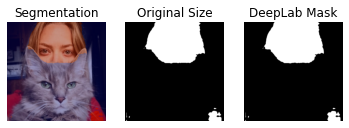

In [19]:
# segmentation, original mask, resize deeplab mask 결과 이미지 출력하기 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Segmentation')
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.set_title('Original Size')
ax2.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
ax3.set_title('DeepLab Mask')
ax3.imshow(img_mask, cmap=plt.cm.binary_r)
ax3.axis('off')

plt.show()

In [20]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 배경 마스크 만들기 
img_bg_blur = cv2.blur(img_bg, (13,13)) #  배경 흐리게 하기 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 흐린 배경과 포커싱 대상 이미지 합치기 

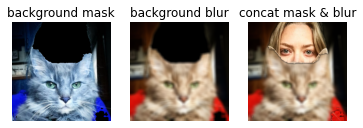

In [21]:
# mask, blur, concat 결과 이미지 출력하기 

fig = plt.figure()
rows = 1
cols = 3 

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img_bg) # img_bg
ax1.set_title('background mask')
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # img_bg_blur
ax2.set_title('background blur')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # img_concat
ax3.set_title('concat mask & blur')
ax3.axis("off")

plt.show()

### 고양이한테 포커싱

In [22]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(400, 400, 3) (513, 513, 3) 15


In [23]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) # segmentation 
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # original 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # resize mask

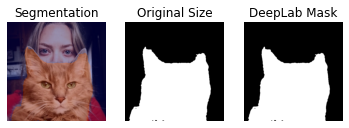

In [24]:
# segmentation, original mask, resize deeplab mask 결과 이미지 출력하기 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Segmentation')
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.set_title('Original Size')
ax2.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
ax3.set_title('DeepLab Mask')
ax3.imshow(img_mask, cmap=plt.cm.binary_r)
ax3.axis('off')

plt.show()

In [25]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 배경 마스크 만들기 
img_bg_blur = cv2.blur(img_bg, (13,13)) #  배경 흐리게 하기 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 흐린 배경과 포커싱 대상 이미지 합치기 

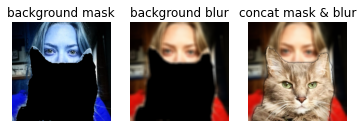

In [26]:
# mask, blur, concat 결과 이미지 출력하기 

fig = plt.figure()
rows = 1
cols = 3 

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img_bg) # img_bg
ax1.set_title('background mask')
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # img_bg_blur
ax2.set_title('background blur')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # img_concat
ax3.set_title('concat mask & blur')
ax3.axis("off")

plt.show()

### 사진에 양이 여러 마리 있는 경우 
시멘틱 세그멘테이션의 특징인 같은 클래스 대상을 구분 못하는 특징을 알 수 있습니다. 

In [34]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sheeps.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1563, 2501, 3)


In [35]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1563, 2501, 3) (320, 513, 3) 17


In [36]:
# 인식 대상을 알기 위한 unique 
np.unique(seg_map)

array([ 0, 15, 17])

In [37]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 17, 17, 0) # 예측 중 양만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) # segmentation 
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # original 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # resize mask

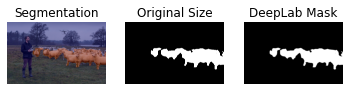

In [38]:
# segmentation, original mask, resize deeplab mask 결과 이미지 출력하기 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Segmentation')
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.set_title('Original Size')
ax2.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
ax3.set_title('DeepLab Mask')
ax3.imshow(img_mask, cmap=plt.cm.binary_r)
ax3.axis('off')

plt.show()

In [39]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 배경 마스크 만들기 
img_bg_blur = cv2.blur(img_bg, (13,13)) #  배경 흐리게 하기 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) # 흐린 배경과 포커싱 대상 이미지 합치기 

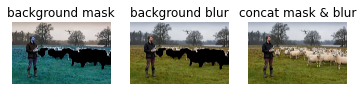

In [42]:
# mask, blur, concat 결과 이미지 출력하기 

fig = plt.figure()
rows = 1
cols = 3 

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img_bg) # img_bg
ax1.set_title('background mask')
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # img_bg_blur
ax2.set_title('background blur')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) # img_concat
ax3.set_title('concat mask & blur')
ax3.axis("off")

plt.show()

## 사진에서 문제점 찾기 & 해결 방법을 제안해보기

In [43]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sheeperson.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(183, 275, 3)


In [44]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(183, 275, 3) (341, 513, 3) 17


In [45]:
# 인식 대상을 알기 위한 unique 
np.unique(seg_map)

array([ 0, 15, 17])

In [46]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 양만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) # segmentation 
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # original 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # resize mask

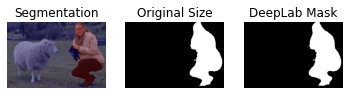

In [47]:
# segmentation, original mask, resize deeplab mask 결과 이미지 출력하기 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Segmentation')
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.set_title('Original Size')
ax2.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
ax3.set_title('DeepLab Mask')
ax3.imshow(img_mask, cmap=plt.cm.binary_r)
ax3.axis('off')

plt.show()

In [50]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(183, 275, 3) (341, 513, 3) 17


In [51]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 17, 17, 0) # 예측 중 양만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) # segmentation 
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # original 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # resize mask

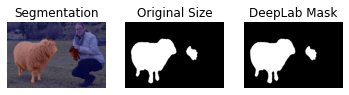

In [52]:
# segmentation, original mask, resize deeplab mask 결과 이미지 출력하기 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Segmentation')
ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
ax2.set_title('Original Size')
ax2.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
ax3.set_title('DeepLab Mask')
ax3.imshow(img_mask, cmap=plt.cm.binary_r)
ax3.axis('off')

plt.show()

DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.<br> 

- 세그멘테이션의 한계<br> 
Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

- 피사계 심도 이해하기<br> 
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

참고자료 : https://ggyul.tistory.com/12

- 3D Depth Camera 활용하기<br> 
카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

참고자료 : https://m.blog.naver.com/panoptics/221336152952

- 깊이 영상(Depth image) 활용하기<br> 
아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

참고자료 : https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
참고자료 : https://sites.google.com/view/struct2depth


- IR(적외선)을 활용한 사례<br> 
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능합니다. 

참고자료 : https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html

위에서 mask 결과를 보면 양을 사람 장갑 부분까지 양으로 인식한 것을 볼 수 있습니다. <br>
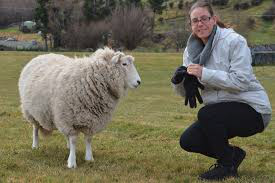 <br>
해당 그림에서 보여지는 문제점은 class에 대한 데이터셋을 구축할 때 정제 요소로 판단할 필요가 있습니다. 실제로 이미지 분류에서는 데이터 정제의 역할이 중요하기 때문에 해당 객체 즉 양과 비슷한 질감을 나타내는 요소가 있다면 해당 특성을 같이 학습하여 같은 대상으로 인식될 수 있습니다. 따라서 이러한 부분은 데이터셋에서 정제함으로서 해결될 수 있는 문제요소라고 판단됩니다. 

또한 3번째 사례에서 그리고 양이 여러마리가 된 상황일 때는 양 한 마리에 대한 인식을 하지 못 하는 것을 알 수 있습니다. 이러한 경우에는 시멘틱 세그멘테이션이 갖고 있는 한계사항에 해당하기 때문에 시멘틱 세그멘테이션보다는 인스턴스 세그멘테이션을 활용해서 같은 클래스더라도 다른 객체로 구분할 수 있도록 해야합니다.<br>
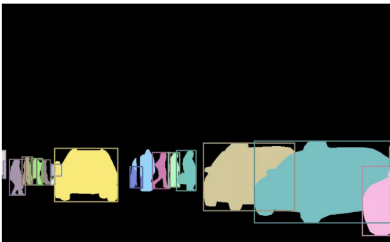 <br>
위에서 보여지는 사례처럼 포커스 대상이 하나하나 객체에 대한 부분을 모두 포함하고 있기 때문에 같은 클래스가 여러개 사진내에 포함되어 있을때 하나씩 인식해야한다면 인스턴스 세그멘테이션을 활용함으로써 문제를 해결할 수 있습니다. 

## 루브릭 
1. 인물모드 사진을 성공적으로 제작하였다.
    - 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다. 
        - 사람만 있는 경우 
        - 사람, 고양이 있는 경우 - 사람 포커싱 
        - 사람, 고양이 있는 경우 - 고양이 포커싱
        - 양이 여러 마리 있는 경우 - 양 포커싱 
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    - 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## 회고
1. 어려웠던 점 <br> 
뒷부분에서 문제점을 찾고 이를 해결하는 방법에 대해 해당 모델이 어떻게 시멘틱 세그멘테이션이 적용되는지 알아야해서, 그 부분을 고민하는게 어려웠습니다. <br> 

2. 알게된 점 <br> 
시멘틱 세그멘테이션에 대해 명확히 이해할 수 있었습니다. **시멘틱 세그멘테이션**은 사진에 있는 모든 픽셀을 해당하는 class로 분류합니다. 이미지에 있는 모든 픽셀에 대해 예측하기 때문에 dense prediction이라고도 합니다. 하지만, 같은 class를 가지는 Instance(객체)간에는 구분하지 않습니다. 한 라벨이 여러개의 객체를 가질때는 그 대상간 구분할 수 없다는 단점이 생기는 것입니다. <br>
그리고 해당 객체에 대한 라벨을 매핑할때는 원핫인코딩을 사용해서 각 라벨별로 맵을 만들어준 다음 argmax를 활용해서 하나의 출력물로 내놓습니다. <br> 

참고 링크:https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb